In [39]:
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


In [40]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS 
from langchain_openai import OpenAIEmbeddings 
from langchain_text_splitters import RecursiveCharacterTextSplitter


In [41]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]


In [42]:
docs=[WebBaseLoader(urls).load() for url in urls]
docs_langchain=[WebBaseLoader(langchain_urls).load() for url in langchain_urls]



In [43]:
doc_list=[item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(doc_list)

vectorstore = FAISS.from_documents(
    documents=doc_splits, 
    embedding=OpenAIEmbeddings()
)

retriever = vectorstore.as_retriever()

##------------------------ 

doc_list_langchain=[item for sublist in docs_langchain for item in sublist]
text_splitter_langchain = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits_langchain = text_splitter_langchain.split_documents(doc_list_langchain)

vectorstore_langchain = FAISS.from_documents(
    documents=doc_splits_langchain, 
    embedding=OpenAIEmbeddings()
)

retriever_langchain = vectorstore_langchain.as_retriever()



In [44]:
retriever.invoke("What is LangGraph?")
retriever_langchain.invoke("What is LangGraph?")


[Document(id='3754bc53-2fbb-426b-9d88-4e70b24f0fa5', metadata={'source': 'https://python.langchain.com/docs/tutorials/chatbot/', 'title': 'Build a Chatbot | 🦜️🔗 LangChain', 'description': 'This tutorial previously used the RunnableWithMessageHistory abstraction. You can access that version of the documentation in the v0.2 docs.', 'language': 'en'}, page_content='So how do we best implement this?\nMessage persistence\u200b\nLangGraph implements a built-in persistence layer, making it ideal for chat applications that support multiple conversational turns.\nWrapping our chat model in a minimal LangGraph application allows us to automatically persist the message history, simplifying the development of multi-turn applications.\nLangGraph comes with a simple in-memory checkpointer, which we use below. See its documentation for more detail, including how to use different persistence backends (e.g., SQLite or Postgres).'),
 Document(id='be69b95a-d63d-4f59-b4d6-0db75a85024b', metadata={'source'

In [45]:
## Retriver to Retriever Tool. 

from langchain.tools.retriever import create_retriever_tool
retriever_tool_langgraph = create_retriever_tool(
    retriever=retriever,
    name="retriever_vector_db_blog",
    description="Search and run information about LangGraph."
)

retriever_tool_langchain = create_retriever_tool(
    retriever=retriever_langchain,
    name="retriever_vector_db_blog",
    description="Search and run information about LangChain."
)

retriever_tool_langgraph 
retriever_tool_langchain 

Tool(name='retriever_vector_db_blog', description='Search and run information about LangChain.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000002468EA2D8A0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000246E81D83E0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000002468EA2D9E0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000246E81D83E0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'),

In [46]:
tools = [retriever_tool_langgraph, retriever_tool_langchain]


In [47]:
## Langgraph Workflows - 
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]
    


In [48]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")
llm.invoke("Hi")


AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.023122226, 'prompt_time': 0.002655195, 'queue_time': 0.2041839, 'total_time': 0.025777421}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_90c2e79dab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--b7674c9a-a49e-49ef-be7c-d6bc11fa5aac-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

In [49]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="llama-3.1-8b-instant")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [50]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

In [51]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="llama-3.1-8b-instant")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [52]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="llama-3.1-8b-instant")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [53]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="llama-3.1-8b-instant")
    response = model.invoke(msg)
    return {"messages": [response]}

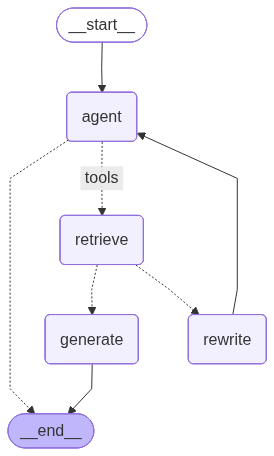

In [54]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool_langgraph,retriever_tool_langchain])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [55]:
graph.invoke({"messages":"What is LangGraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is LangGraph?', additional_kwargs={}, response_metadata={}, id='dc82b2a2-49ce-4f44-a64f-a5bad1afb52b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8kjrggen9', 'function': {'arguments': '{"query":"LangGraph definition"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 308, 'total_tokens': 328, 'completion_time': 0.025045264, 'prompt_time': 0.018571768, 'queue_time': 0.203656086, 'total_time': 0.043617032}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_90c2e79dab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--51a042b6-8bbc-40d1-b81e-3e5c02bb2125-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'LangGraph definition'}, 'id': '8kjrggen9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 308, 'output_tokens': 20, 'total_tokens': 328}),
  ToolMessage(co

In [56]:
graph.invoke({"messages":"What is LangChain?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is LangChain?', additional_kwargs={}, response_metadata={}, id='c73181b2-7d0d-4eb0-bc6f-61aea28e4174'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ffnpje8hr', 'function': {'arguments': '{"query":"LangChain"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 308, 'total_tokens': 327, 'completion_time': 0.023841607, 'prompt_time': 0.01694492, 'queue_time': 0.204259165, 'total_time': 0.040786527}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_50a6be1b6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4d2c2092-ed64-40bc-8096-12f16ce0e145-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'LangChain'}, 'id': 'ffnpje8hr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 308, 'output_tokens': 19, 'total_tokens': 327}),
  ToolMessage(content='Tutorials | 🦜️🔗 

In [58]:
graph.invoke({"messages":"What is Machine Learning?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is Machine Learning?', additional_kwargs={}, response_metadata={}, id='d0830504-f9c7-4058-a832-b00a150d6dd7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'my9nacbk0', 'function': {'arguments': '{"query":"Machine Learning definition"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 308, 'total_tokens': 328, 'completion_time': 0.028907606, 'prompt_time': 0.017024081, 'queue_time': 0.203386491, 'total_time': 0.045931687}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_90c2e79dab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--07011a8e-e5c9-4816-b50a-9a1c78dafa00-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'Machine Learning definition'}, 'id': 'my9nacbk0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 308, 'output_tokens': 20, 'total_tokens': 32